Pix2pix training
================



In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from IPython import display # we will use this to clear the results
import numpy as np
import matplotlib.pyplot as plt
import os, sys

## Datasets



Download a dataset, e.g.:

-   Standard pix2pix datasets: [http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/](http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/)
-   Comic faces: [https://www.kaggle.com/datasets/defileroff/comic-faces-paired-synthetic](https://www.kaggle.com/datasets/defileroff/comic-faces-paired-synthetic)
-   Maps: [https://www.kaggle.com/datasets/alincijov/pix2pix-maps](https://www.kaggle.com/datasets/alincijov/pix2pix-maps)
-   Rembrandt: [https://www.kaggle.com/datasets/grafstor/rembrandt-pix2pix-dataset](https://www.kaggle.com/datasets/grafstor/rembrandt-pix2pix-dataset)
-   Depth [https://www.kaggle.com/datasets/greg115/pix2pix-depth](https://www.kaggle.com/datasets/greg115/pix2pix-depth)

Or create your own using the notebook.



## Load and preprocess dataset



Let&rsquo;s first specify the path of our dataset and the desired image size (do not change the latter):



In [13]:
dataset_path = "./datasets/edge2comics/" # Change this for your custom dataset
img_channels = 3
img_size = 256
batch_size = 1

Each training image in a standard pix2pix dataset consists of one imgage divided into two adjacent **source** and **target** images.
The layout of the source and target may vary from training set to trainig set, so we provide a `target_index` flag the determines on which side the target is (`0` if on the left and `1` if on the right). Set this so the examples from the dataset appear with the source image to the left.

The following code also **augments** the dataset by applying random uniform scaling (by upscaling and cropping) and random mirroring to the input output pairs. This should lead to a more stable model according to the original pix2pix paper. Finally the images ar normalized to the [-1,1] range as required by our GAN-based model.

We will organize the dataset in batches of size `1`, as that is generally suggested for pix2pix models. That means that we will update the weights of the model for each image pair separately.

Run the code below and examine the resulting example images. Then set the `target_index` variable to reflect the position of the target image. That is `target_index=0` if the target image is on the left and `target_index=1` if it is on the right.



Found 200 files belonging to 1 classes.


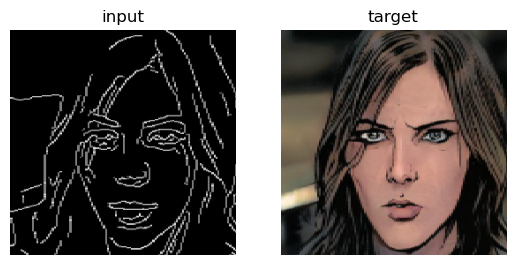

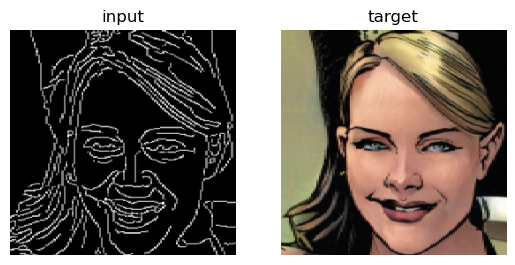

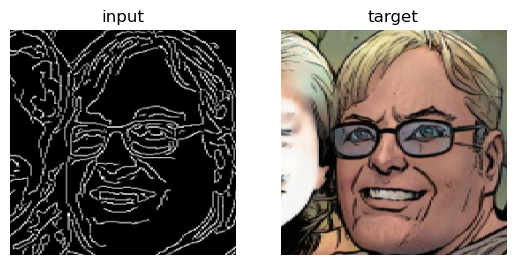

In [14]:
target_index = 1

def resize(input_image, target_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  target_image = tf.image.resize(target_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, target_image

def random_crop(input_image, target_image):
  stacked_image = tf.stack([input_image, target_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, 256, 256, 3])

  return cropped_image[0], cropped_image[1]


@tf.function()
def random_jitter(input_image, target_image):
  # Resizing to 286x286
  input_image, target_image = resize(input_image, target_image, 286, 286)

  # Random cropping back to 256x256
  input_image, target_image = random_crop(input_image, target_image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    input_image = tf.image.flip_left_right(input_image)
    target_image = tf.image.flip_left_right(target_image)

  return input_image, target_image


def preprocess_image(image):
    # Split each image tensor into two tensors:
    w = tf.shape(image)[1]
    w = w // 2

    if target_index==0:
        input_image = image[:, w:, :]
        target_image = image[:, :w, :]
    else:
        target_image = image[:, w:, :]
        input_image = image[:, :w, :]
    # Jitter
    input_image, target_image = random_jitter(input_image, target_image)
    # Normalize
    input_image = (input_image / 127.5) - 1
    target_image = (target_image / 127.5) - 1
    return input_image, target_image


dataset = keras.utils.image_dataset_from_directory(
    dataset_path, label_mode=None, image_size=(img_size*2, img_size), batch_size=None)

dataset = dataset.map(preprocess_image)
dataset = dataset.batch(batch_size)

for i, (input_img, output_img) in enumerate(dataset):
    plt.figure()
    plt.subplot(1,2,1)
    plt.title('input')
    plt.imshow((input_img.numpy() * 127.5 + 127.5).astype("int32")[0])
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.title('target')
    plt.imshow((output_img.numpy() * 127.5 + 127.5).astype("int32")[0])
    plt.axis('off')
    plt.show()
    if i==2:
        break

## Build  the model



The pix2pix model is a conditional generative adversarial network (cGAN). A CGAN
is a type of GAN model used for generating new data samples with specific
attributes or characteristics. In a CGAN, both the generator and discriminator
are *conditioned* on additional information, such as class labels, tags, or
other types of metadata. The generator network takes in random noise as well as
the conditional information as input and produces a new data sample that matches
the desired attributes. The discriminator network, on the other hand, tries to
distinguish between the generated samples and real samples based on both their
visual appearance and the conditional information. For the case of a pix2pix
model the network is conditioned on an image, which should be transformed into
an output image.



### Generator



Differently from a DC-GAN, the generator of the pix2pix model is based on the
[U-net](https://arxiv.org/abs/1505.04597) architecture. A U-net model is a CNN architecture that is typically used
for image segmentation tasks. The name U-net derives from the architecture,
which resembles the letter &ldquo;U&rdquo;. It consists of two main parts: an *encoder* and
a *decoder*. The encoder part consists of a series of convolutional layers,
which reduce the spatial dimensionality of the input image while increasing its
depth. This is followed by a bottleneck layer that extracts the most important
features from the input image. The decoder part is a &ldquo;mirror image&rdquo; of the
encoder. It consists of a series of layers that gradually increase the spatial
dimensionality of the output, while decreasing its depth. This is similar to
what we have seen in the DC-GAN example, but here we use a &ldquo;transposed
convolution&rdquo; layer (`Conv2DTranspose`), while in the DCGAN example we used an
upscaling followed by a convolution. The output of each layer in the encoder is
also concatenated with the output of another layer in the decoder. This creates
&ldquo;skip connections&rdquo; that help preserve spatial information and avoid information
loss during the encoding and decoding process.



In [15]:
def downsample(filters, size, apply_batchnorm=True):
    init = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                kernel_initializer=init, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result


def upsample(filters, size, apply_dropout=False):
    init = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                        padding='same',
                                        kernel_initializer=init,
                                        use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result


def build_generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
        downsample(128, 4),  # (batch_size, 64, 64, 128)
        downsample(256, 4),  # (batch_size, 32, 32, 256)
        downsample(512, 4),  # (batch_size, 16, 16, 512)
        downsample(512, 4),  # (batch_size, 8, 8, 512)
        downsample(512, 4),  # (batch_size, 4, 4, 512)
        downsample(512, 4),  # (batch_size, 2, 2, 512)
        downsample(512, 4),  # (batch_size, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
        upsample(512, 4),  # (batch_size, 16, 16, 1024)
        upsample(256, 4),  # (batch_size, 32, 32, 512)
        upsample(128, 4),  # (batch_size, 64, 64, 256)
        upsample(64, 4),  # (batch_size, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(img_channels, 4,
                                            strides=2,
                                            padding='same',
                                            kernel_initializer=initializer,
                                            activation='tanh')  # (batch_size, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

generator = build_generator()
generator.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_18 (Sequential)     (None, 128, 128, 64  3072        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 sequential_19 (Sequential)     (None, 64, 64, 128)  131584      ['sequential_18[0][0]']          
                                                                                            

### Discriminator



The discriminator in the pix2pix model is a convolutional &ldquo;PatchGAN classifier&rdquo;.
It tries to classify if each **image patch** if it is real or not real. In the
following decoder, each 30 x 30 image patch of the output classifies a 70 x 70
portion of the input image.



In [16]:
def build_discriminator():
    init = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=init,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=init)(zero_pad2)  # (batch_size, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

discriminator = build_discriminator()
discriminator.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 target_image (InputLayer)      [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_15 (Concatenate)   (None, 256, 256, 6)  0           ['input_image[0][0]',            
                                                                  'target_image[0][0]']     

### Generate some images before training



Let&rsquo;s generate some images before training to see what the network will output



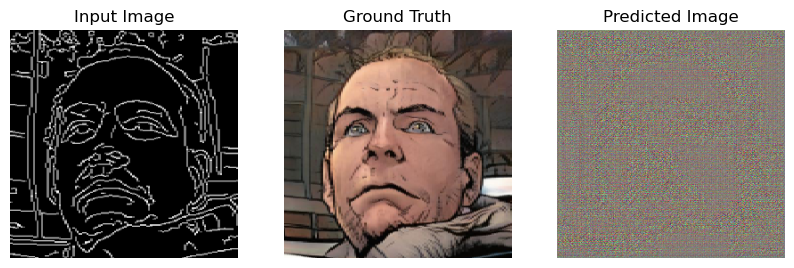

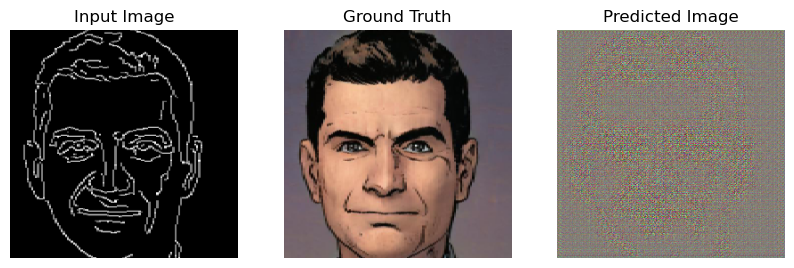

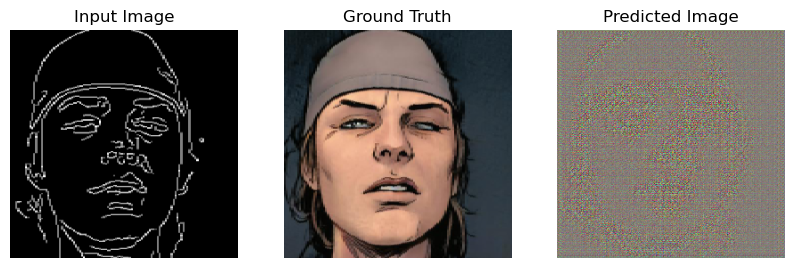

In [17]:
def generate_images(model, test_input, tar, fname=''):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(10, 10))


    if tar is not None:
        display_list = [test_input[0], tar[0], prediction[0]]
        title = ['Input Image', 'Ground Truth', 'Predicted Image']
    else:
        display_list = [test_input[0], prediction[0]]
        title = ['Input Image', 'Predicted Image']

    for i in range(len(title)):
        plt.subplot(1, len(title), i+1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')

    if fname:
        plt.savefig(fname)
        plt.close()
    else:
        plt.show()

for example_input, example_target in dataset.take(3):
    generate_images(generator, example_input, example_target)

## Training the model



### Generator loss



GANs learn a loss that adapts to the data, while cGANs learn a structured loss that penalizes a possible structure that differs from the network output and the target image, as described in the [pix2pix paper](https://arxiv.org/abs/1611.07004).

-   The generator loss is a sigmoid cross-entropy loss of the generated images and an array of ones.
-   The pix2pix paper also mentions the L1 loss, which is a MAE (mean absolute error) between the generated image and the target image.
-   This allows the generated image to become structurally similar to the target image.
-   The formula to calculate the total generator loss is `gan_loss + LAMBDA * l1_loss`, where `LAMBDA = 100`. This value was decided by the authors of the paper.

Feel free to experiment with modifying the value of `LAMBDA` (if you have time to spare:))



In [18]:
LAMBDA = 100
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_fn(tf.ones_like(disc_generated_output), disc_generated_output)

    # Mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

### Discriminator loss



The discriminator<sub>loss</sub> function takes 2 inputs: real images and generated images.

-   The `real_loss` is a sigmoid cross-entropy loss of the real images and an array of ones (since these are the real images).
-   The `generated_loss` is a sigmoid cross-entropy loss of the generated images and an array of zeros (since these are the fake images).
-   The `total_loss` is simply the sum of `real_loss` and `generated_loss`.



In [19]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_fn(tf.ones_like(disc_real_output), disc_real_output)
  generated_loss = loss_fn(tf.zeros_like(disc_generated_output), disc_generated_output)
  total_disc_loss = real_loss + generated_loss
  return total_disc_loss

### Training loop



The training loop procedes as follows:

-   For each example input we generate an output.
-   The discriminator receives the input image and the generated image as the first input. The second input is the input image and the target image.
-   Next, calculate the generator and the discriminator loss.
-   Then, calculate the gradients of the loss with respect to both the generator and the discriminator variables (inputs) and apply those to the optimizer.



In [20]:
epochs = 100
save_interval = 1

model_path = "./models/edges2comics" # Can change. Model files and resulting images will be saved in this directory
os.makedirs(model_path, exist_ok=True) # this actually creates the directory if it does not exist

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

@tf.function
def train_step(batch):
    input_image, target = batch
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

        generator_gradients = gen_tape.gradient(gen_total_loss,
                                                generator.trainable_variables)
        discriminator_gradients = disc_tape.gradient(disc_loss,
                                                    discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(generator_gradients,
                                                generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                                    discriminator.trainable_variables))

    return gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss

g_losses = []
d_losses = []


for epoch in range(epochs):
    n = dataset.cardinality() # The number of batches per epoch
    # Iterate over all batches
    batch_d_losses = []
    batch_g_losses = []
    for i, batch in enumerate(dataset):
        # Updte parameters for this batch
        gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss = train_step(batch)

        # Store losses for batch, we will average these for the whole epoch for a more stable visualization
        batch_d_losses.append(disc_loss)
        batch_g_losses.append(gen_total_loss)

        sys.stdout.write("\r" + "Epoch %d - image %d of %d "%(epoch+1, i+1, n) + "[gen total loss: "+str(gen_total_loss)+ " | disc loss: "+str(disc_loss)+"]")

    # Book-keeping:
    # Visualize losses and one example image for the epoch
    g_losses.append(np.mean(batch_g_losses))
    d_losses.append(np.mean(batch_d_losses))

    display.clear_output(wait=True)
    plt.figure(figsize=(6,5))
    plt.title('Losses')
    plt.plot(np.array(d_losses)*40, label='Discriminator')
    plt.plot(g_losses, label='Generator')
    plt.legend()
    plt.savefig(os.path.join(model_path, "losses.pdf"))
    plt.close()

    # Save some example images and store model file
    if epoch % save_interval == 0:
        print('Saving epoch %d to %s'%(epoch+1, model_path))
        for j, (example_input, example_target) in enumerate(dataset.take(3)):
            generate_images(generator, example_input, example_target,
                            fname=os.path.join(model_path, "e%03d_generated_image_%d.png" % (epoch+1, j+1)))
        generator.save(os.path.join(model_path, "e%0d_generator.hd5"%(epoch+1)), save_format='h5')

Saving epoch 54 to ./models/edges2comics
Epoch 55 - image 103 of 200 [gen total loss: tf.Tensor(31.293, shape=(), dtype=float32) | disc loss: tf.Tensor(0.28009492, shape=(), dtype=float32)]2)]